# Geospatial Matching Optimization

This project is designed to showcase how to improve the speed of a polygon matching procedure. 

I will use terms like **_"geospatial-native"_** or **_"geosptially-optimized"_** when describing and running two approaches to the matching process. I describe a **_geospatially naive_** approach as one that does not take full advantage of the latest advances in geospatial data engineering and analysis.

There are two main areas that could benefit from taking a geospatial-native approach:

1. Data encoding, fetching, and storage
2. Searching for Overlaps

We will use both a non-geospatial-native and geospatial-native approach to matching blos in a dataset. We will benchmark the execution time, CPU usage, and memory usage for both to see how they differ, with the implicit hypothesis being that the geospatial-native approaches will be more efficient and process more quickly.

## Imports

In [44]:
import geopandas as gpd
import pandas as pd
import shapely
import h3
import time
import helpers as h
import parallel_processing as p
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from shapely.wkt import dumps, loads
from pathlib import Path
import multiprocessing as mp
import datetime
import psycopg2
from psycopg2 import sql, extras
import random
import duckdb
duckdb.sql('INSTALL spatial;')
duckdb.sql('LOAD spatial;')
from pathlib import Path

# ensure helpers is loaded correctly as I work on it
import importlib
importlib.reload(h)
importlib.reload(p)

<module 'parallel_processing' from '/Users/sra/files/projects/matching_optimization/parallel_processing.py'>

## Retrieve Data

As part of the project, I previously downloaded a 600,000-row slice of data where the `YEAR` = 2024 and the `MONTH` is between March and July.

Go to [this notebook](retrieve_and_concat_data.ipynb) to see my work in [retrieving](retrieve_and_concat_data.ipynb#download) and [converting](retrieve_and_concat_data.ipynb#concat) the data.

The `geometry` column stores the spatial information, which is sourced from the `BLOB_POLYGON` column within the same table.

In [4]:
gdf_path = Path('data/blob_20250307.parquet')
gdf = gpd.read_parquet(gdf_path)
gdf.head()

,BLOB_ID,FULL_IMG_ID,POINT,SIZE,POLYGON_BOUNDRY_BOX,BLOB_POLYGON,GEO_HASHES,CONSTRUCTION_STAGE,BUILDING_TYPE,CS_MODEL_ID,...,IS_VALID,IS_IMPUTED,IS_EXCLUDED,COUNTY,IS_OVERLAPPING_FOOTPRINT,IS_OVERLAPPING_ROAD,FOOTPRINT_ID,ROAD_DATA_ID,pgt_ctid,geometry
0,BID_4b0de362-432b-4169-880b-2502fe191e45,FIID_eeca1e04-8ba1-43cb-931c-81c560491477_2024...,POINT (-96.57220292317847 32.777977159601775),519,POLYGON ((-96.57224768518518 32.77805324074072...,POLYGON ((-96.57224768518518 32.77797916666665...,9vg66rn,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,DALLAS,True,False,FP_ID_36b25e18-56d6-482d-8f54-dac7c70c6687,None,"(1000,6)","POLYGON ((-96.57225 32.77798, -96.57224 32.777..."
1,BID_8ae754b5-026d-4aac-9b9c-7b473bcf1f79,FIID_46cf3f0f-2345-41e0-8e50-fcf561da16c4_2024...,POINT (-95.33409120370364 29.674920974576246),1180,POLYGON ((-95.33415972222215 29.67505787037034...,POLYGON ((-95.33415972222215 29.67503935185182...,9vk0yd5,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,HARRIS,True,False,FP_ID_c7fa7535-5ebb-4132-9814-e695c737a316,None,"(1000000,6)","POLYGON ((-95.33416 29.67504, -95.33416 29.675..."
2,BID_ea519744-3092-4bb3-a340-19afe400056f,FIID_f7968076-35bc-42c8-b417-f88e8fafd619_2024...,POINT (-96.74267940156228 33.196998841454544),1017,POLYGON ((-96.74277546296292 33.19707175925927...,POLYGON ((-96.74277546296292 33.19699305555556...,9vghye6,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,COLLIN,True,False,FP_ID_6f9bcbaf-4075-4ceb-aab1-ccdc562744e7,None,"(10000001,2)","POLYGON ((-96.74278 33.19699, -96.74277 33.196..."
3,BID_ea962ddc-c9ad-4a0a-905e-2012e0d6485d,FIID_a2ae6d14-612c-4123-bd66-636f6821c091_2024...,POINT (-96.72505400860906 33.16324660904856),826,POLYGON ((-96.72512731481478 33.16331712962967...,POLYGON ((-96.72512731481478 33.16324768518522...,9vghwvp|9vghwvn,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,COLLIN,True,False,FP_ID_3d617f10-f756-462f-b098-00badc42438a,None,"(10000002,6)","POLYGON ((-96.72513 33.16325, -96.72512 33.163..."
4,BID_ea9a59f0-7f15-4371-ac86-096cf4eeaf3f,FIID_f7968076-35bc-42c8-b417-f88e8fafd619_2024...,POINT (-96.7388098211761 33.202477229997186),1310,POLYGON ((-96.73887731481477 33.20259027777779...,POLYGON ((-96.73887731481477 33.20255787037038...,9vghysm|9vghysk,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,False,COLLIN,True,False,FP_ID_3aa44e93-ea83-4f15-b570-078dad879910,None,"(10000003,2)","POLYGON ((-96.73888 33.20256, -96.73887 33.202..."


View the data in a plot:

In [52]:
conus = gpd.read_parquet('data/conus_admin.parquet')
# conus.to_csv('data/conus_admin.csv')

In [42]:
print(conus.shape)
print(conus['shapeName'].nunique())
print(conus['STATEFP'].nunique())
conus.head()

(3108, 25)
1801
1


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,...,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,area_fips,geometry
0,Highland,,52423323B51867153498623,USA,ADM2,31,039,00835841,31039,0500000US31039,...,339,30700,11694,A,1477563042,10772508,+41.9158651,-096.7885168,31039,"POLYGON ((-83.83441 39.24572, -83.83587 39.223..."
1,Alpine,,52423323B67588574079428,USA,ADM2,31,039,00835841,31039,0500000US31039,...,339,30700,11694,A,1477563042,10772508,+41.9158651,-096.7885168,31039,"POLYGON ((-120.07240 38.70277, -119.96496 38.7..."
2,Escambia,,52423323B97123089850170,USA,ADM2,31,039,00835841,31039,0500000US31039,...,339,30700,11694,A,1477563042,10772508,+41.9158651,-096.7885168,31039,"POLYGON ((-87.57130 30.99784, -87.54856 30.997..."
3,Lawrence,,52423323B54167037237770,USA,ADM2,31,039,00835841,31039,0500000US31039,...,339,30700,11694,A,1477563042,10772508,+41.9158651,-096.7885168,31039,"POLYGON ((-87.75960 38.84952, -87.68415 38.852..."
4,Wayne,,52423323B18579387327768,USA,ADM2,31,039,00835841,31039,0500000US31039,...,339,30700,11694,A,1477563042,10772508,+41.9158651,-096.7885168,31039,"POLYGON ((-88.91046 31.82665, -88.80918 31.832..."


<Axes: >

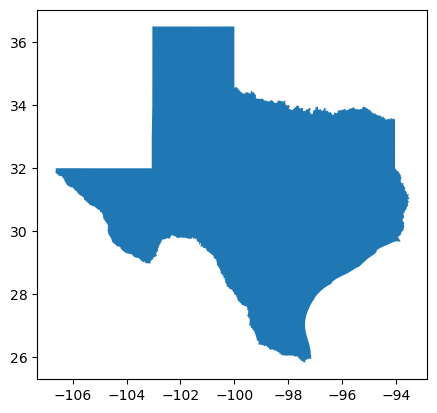

In [53]:
# Read the Texas boundary from the GeoJSON file
texas_boundary = gpd.read_file('data/Texas_State_Boundary_1106215059088919288.geojson')

# Extract the Texas polygon
texas_polygon = texas_boundary.geometry.iloc[0]
texas_wkt = texas_polygon.wkt

texas_boundary.plot()

In [ ]:
# Register the DataFrames with DuckDB

duckdb.register('conus', conus)
texas_boundary = gpd.read_file('data/Texas_State_Boundary_1106215059088919288.geojson')
duckdb.register('texas', texas_boundary)

# Use a subquery to get Texas polygon and filter CONUS features that intersect
query = """
SELECT c.*
FROM conus AS c
WHERE ST_Intersects(
    c.geometry,
    (SELECT t.geometry FROM texas AS t LIMIT 1)
)
"""
result = duckdb.sql(query).fetchdf()
result.head()

NotImplementedException: Not implemented Error: Data type 'geometry' not recognized

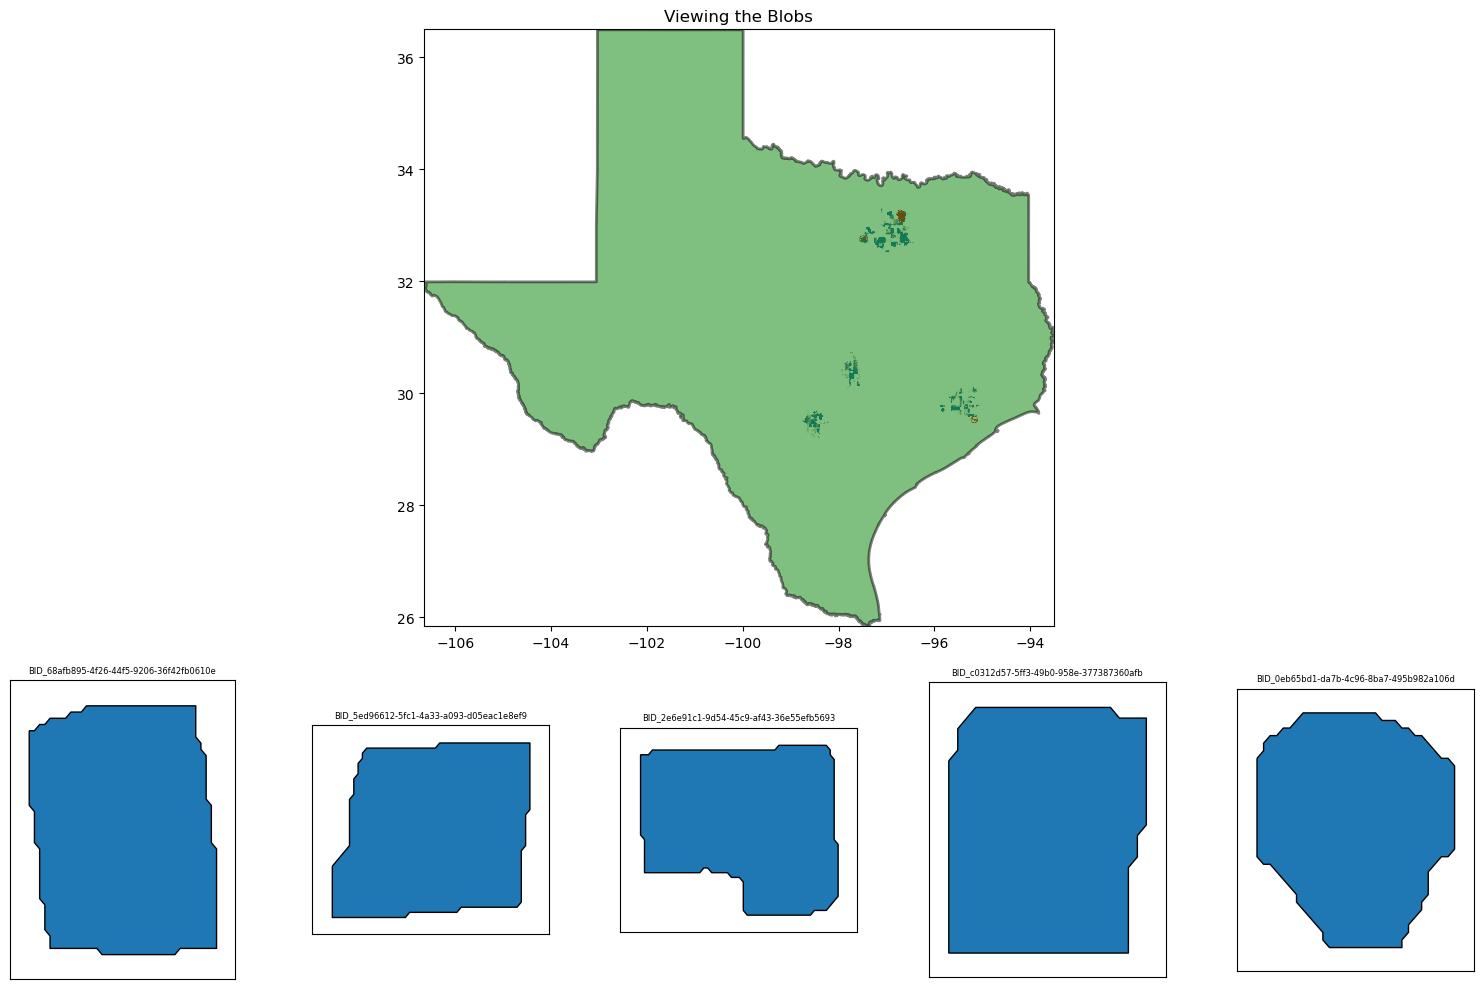

In [58]:
fig_location = Path('figs/_blobs_plot.png')
if not fig_location.exists():
    sample_size = 5
    gdf_sample = gdf.sample(n=sample_size, random_state=42)

    # instantiate figure
    fig = plt.figure(figsize=(15, 10))

    # instantiate overall gridspec layout
    # main plot = 2x height, subplots = 1x height
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

    # plot blobs on main
    ax_main = fig.add_subplot(gs[0])
    gdf.plot(ax=ax_main)
    gdf_sample.plot(ax=ax_main, color='red', linewidth=5, edgecolor='red')
    ax_main.set_title('Viewing the Blobs')
    
    # zoom on texas as the blob data is focused there
    ax_main.set_xlim(-106.65, -93.51)
    ax_main.set_ylim(25.84, 36.5)

    # add us boundary
    texas_boundary = gpd.read_file('data/Texas_State_Boundary_1106215059088919288.geojson')
    texas_boundary.plot(ax=ax_main, alpha=0.5, color='green', edgecolor='black', linewidth=2)

    ax_main.set_title(f'Viewing the Blobs')

    # instantiate subplot gridspecs
    gs_subplots = gridspec.GridSpecFromSubplotSpec(
        nrows=1, 
        ncols=sample_size, 
        subplot_spec=gs[1],
        wspace=0.3)

    # view sample of polygons in gridspec
    for i, (idx, row) in enumerate(gdf_sample.iterrows()):
        
        # plot len(sample_size) subsets
        ax = fig.add_subplot(gs_subplots[0, i])
        subset = gdf_sample.iloc[[i]]
        subset.plot(ax=ax, edgecolor='black')

        # adjust zoom
        bounds = subset.geometry.bounds.values[0]
        x_buffer = (bounds[2] - bounds[0]) / 10
        y_buffer = (bounds[3] - bounds[1]) / 10
        ax.set_xlim(bounds[0] - x_buffer, bounds[2] + x_buffer)
        ax.set_ylim(bounds[1] - y_buffer, bounds[3] + y_buffer)
        
        # title
        ax.set_title(f"{row['BLOB_ID']}", fontsize=6)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    # # plt.savefig('figs/blobs_plot.pdf', bbox_inches='tight') # this pdf is too large
    plt.savefig('figs/blobs_plot.png', bbox_inches='tight')

    plt.show()
else:
    img = plt.imread(fig_location)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

computing centroids


/var/folders/n3/q8wb235x57n_sx2q14dsngjr0000gn/T/ipykernel_97980/57512179.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid
/var/folders/n3/q8wb235x57n_sx2q14dsngjr0000gn/T/ipykernel_97980/57512179.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid_x'] = gdf.centroid.x
/var/folders/n3/q8wb235x57n_sx2q14dsngjr0000gn/T/ipykernel_97980/57512179.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid_y'] = gdf.centroid.y


running kmeans
compute boxes
plotting main texas boundary
main plot
create subplots for each cluster


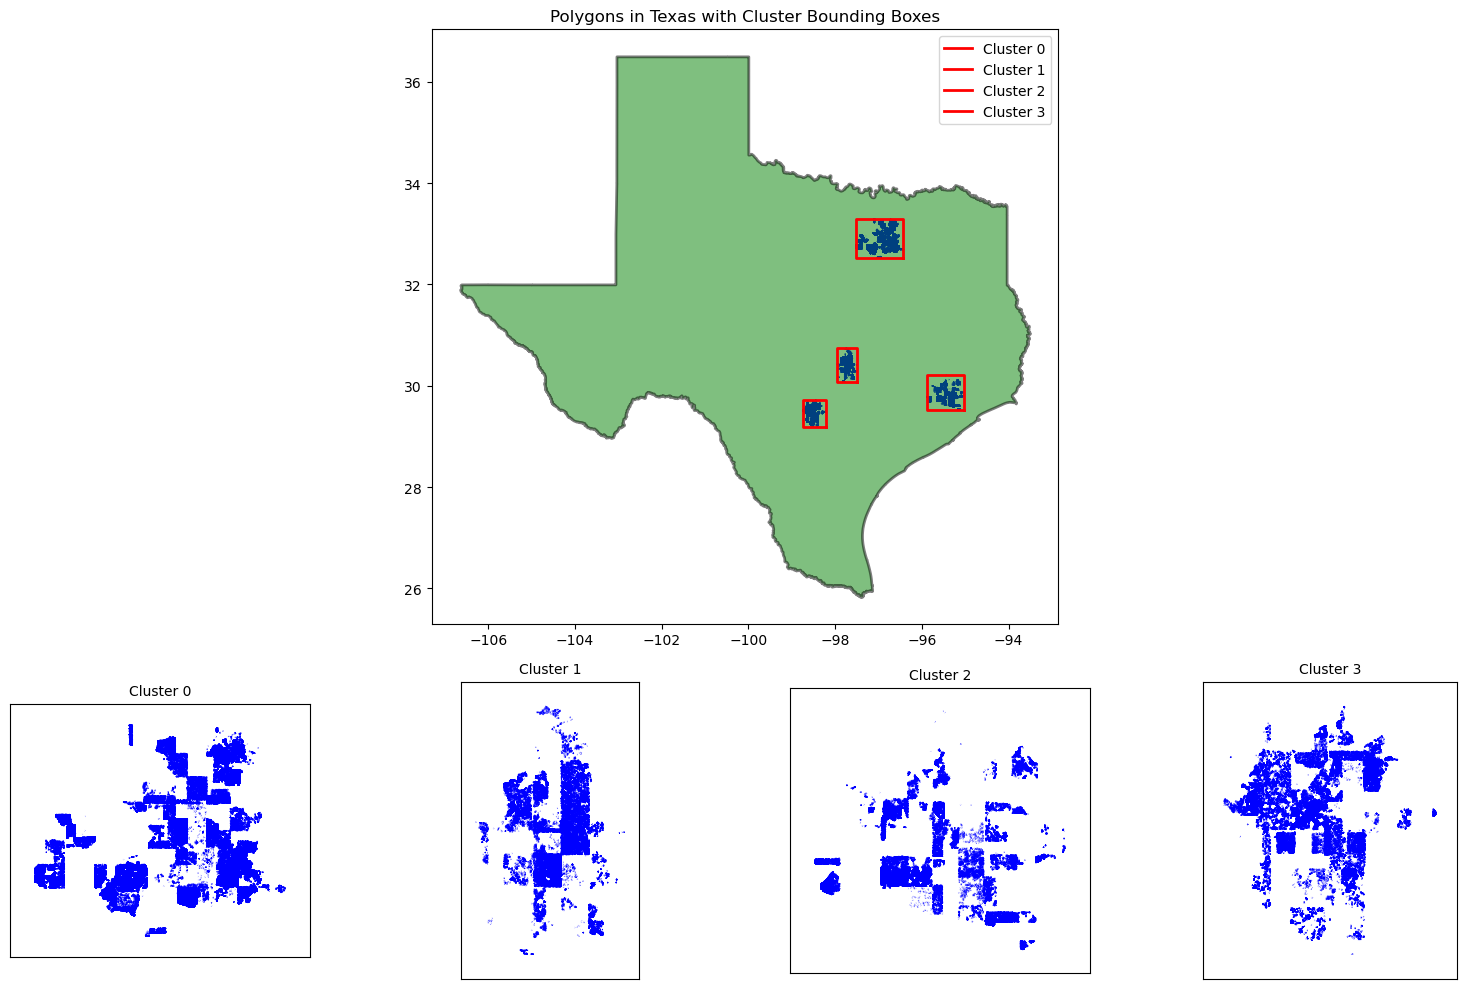

In [ ]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans

# Assume gdf is your GeoDataFrame with the polygon data in Texas
# Compute centroids
print('computing centroids')
gdf_plot = gdf.to_crs()
gdf_plot['centroid'] = gdf_plot.geometry.centroid
gdf_plot['centroid_x'] = gdf_plot.centroid.x
gdf_plot['centroid_y'] = gdf_plot.centroid.y

# Run k-means clustering (ensure coordinates are in a projected CRS if precision matters)
print('running kmeans')
X = gdf_plot[['centroid_x', 'centroid_y']].values
kmeans = KMeans(n_clusters=4, random_state=42)
gdf_plot['cluster'] = kmeans.fit_predict(X)

# Compute bounding boxes for each cluster
print('compute boxes')
clusters = {}
for cluster_label, group in gdf_plot.groupby('cluster'):
    minx, miny, maxx, maxy = group.total_bounds
    clusters[cluster_label] = box(minx, miny, maxx, maxy)

# Plotting main Texas boundary, the polygons, and the bounding boxes
print('plotting main texas boundary')
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

# Main plot
print('main plot')
ax_main = fig.add_subplot(gs[0])
gdf_plot.plot(ax=ax_main, facecolor='none', edgecolor='blue', linewidth=1)
# Optionally, plot the Texas boundary if you have it
texas_boundary = gpd.read_file('data/Texas_State_Boundary_1106215059088919288.geojson')
texas_boundary.plot(ax=ax_main, alpha=0.5, color='green', edgecolor='black', linewidth=2)
# Plot bounding boxes for clusters
for cluster_label, bbox in clusters.items():
    xs, ys = bbox.exterior.xy
    ax_main.plot(xs, ys, color='red', linewidth=2, label=f'Cluster {cluster_label}')
ax_main.set_title('Polygons in Texas with Cluster Bounding Boxes')
ax_main.legend()

# Create subplots for each cluster
print('create subplots for each cluster')
gs_sub = gridspec.GridSpecFromSubplotSpec(
    nrows=1, 
    ncols=4, 
    subplot_spec=gs[1],
    wspace=0.3)

for cluster_label, group in gdf_plot.groupby('cluster'):
    ax = fig.add_subplot(gs_sub[cluster_label])
    group.plot(ax=ax, facecolor='none', edgecolor='blue')
    # Adjust view to the cluster bounding box with a little buffer
    minx, miny, maxx, maxy = group.total_bounds
    x_buffer = (maxx - minx) * 0.1
    y_buffer = (maxy - miny) * 0.1
    ax.set_xlim(minx - x_buffer, maxx + x_buffer)
    ax.set_ylim(miny - y_buffer, maxy + y_buffer)
    ax.set_title(f'Cluster {cluster_label}', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans

# Assume gdf is your GeoDataFrame with the polygon data in Texas

# Reproject to a Texas-appropriate projected CRS (EPSG:3083)
gdf_projected = gdf.to_crs("EPSG:3083")
print("computing centroids after reprojection")
gdf_projected['centroid'] = gdf_projected.geometry.centroid
gdf_projected['centroid_x'] = gdf_projected.centroid.x
gdf_projected['centroid_y'] = gdf_projected.centroid.y

# Run k-means clustering (ensure coordinates are in a projected CRS if precision matters)
print('running kmeans')
X = gdf_projected[['centroid_x', 'centroid_y']].values
kmeans = KMeans(n_clusters=4, random_state=42)
gdf_projected['cluster'] = kmeans.fit_predict(X)

# Compute bounding boxes for each cluster
print('compute boxes')
clusters = {}
for cluster_label, group in gdf_projected.groupby('cluster'):
    minx, miny, maxx, maxy = group.total_bounds
    clusters[cluster_label] = box(minx, miny, maxx, maxy)

# Define unique line styles and colors (Okabe–Ito palette)
line_styles = ['-', '--', '-.', ':']
line_colors = ['#0072B2', '#E69F00', '#009E73', '#CC79A7']

# Plotting main Texas boundary, the polygons, and the bounding boxes
print('plotting main texas boundary')
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

# Main plot
print('main plot')
ax_main = fig.add_subplot(gs[0])
gdf_projected.plot(ax=ax_main, facecolor='none', edgecolor='blue', linewidth=1)

# Plot the Texas boundary
texas_boundary = gpd.read_file('data/Texas_State_Boundary_1106215059088919288.geojson')
texas_boundary = texas_boundary.to_crs("EPSG:3083")
texas_boundary.plot(ax=ax_main, alpha=0.5, color='green', edgecolor='black', linewidth=2)

# Plot bounding boxes with unique line styles and colors
for cluster_label, bbox in clusters.items():
    xs, ys = bbox.exterior.xy
    style = line_styles[cluster_label % len(line_styles)]
    color = line_colors[cluster_label % len(line_colors)]
    ax_main.plot(xs, ys, color=color, linestyle=style, linewidth=4, label=f'Cluster {cluster_label}')

ax_main.set_title('Texas Blobs with Cluster Bounding Boxes')
ax_main.legend()
ax_main.set_xticks([])
ax_main.set_yticks([])

# Create subplots for each cluster
print('create subplots for each cluster')
gs_sub = gridspec.GridSpecFromSubplotSpec(
    nrows=1, 
    ncols=4, 
    subplot_spec=gs[1],
    wspace=0.3)

for cluster_label, group in gdf_projected.groupby('cluster'):
    ax = fig.add_subplot(gs_sub[cluster_label])
    group.plot(ax=ax, facecolor='none', edgecolor='blue')
    # Adjust view to the cluster bounding box with a little buffer
    minx, miny, maxx, maxy = group.total_bounds
    x_buffer = (maxx - minx) * 0.1
    y_buffer = (maxy - miny) * 0.1
    ax.set_xlim(minx - x_buffer, maxx + x_buffer)
    ax.set_ylim(miny - y_buffer, maxy + y_buffer)
    ax.set_title(f'Cluster {cluster_label}', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Draw the corresponding bounding box on the subplot
    bbox = clusters[cluster_label]
    bxmin, bymin, bxmax, bymax = bbox.bounds
    width = bxmax - bxmin
    height = bymax - bymin
    style = line_styles[cluster_label % len(line_styles)]
    color = line_colors[cluster_label % len(line_colors)]
    rect = plt.Rectangle((bxmin, bymin), width, height, fill=False, 
                         edgecolor=color, linestyle=style, linewidth=4)
    ax.add_patch(rect)

plt.tight_layout()
plt.savefig('figs/blob_map_with_clusters.png', bbox_inches='tight')
plt.show()

computing centroids after reprojection
running kmeans
compute boxes
plotting main texas boundary
main plot
create subplots for each cluster


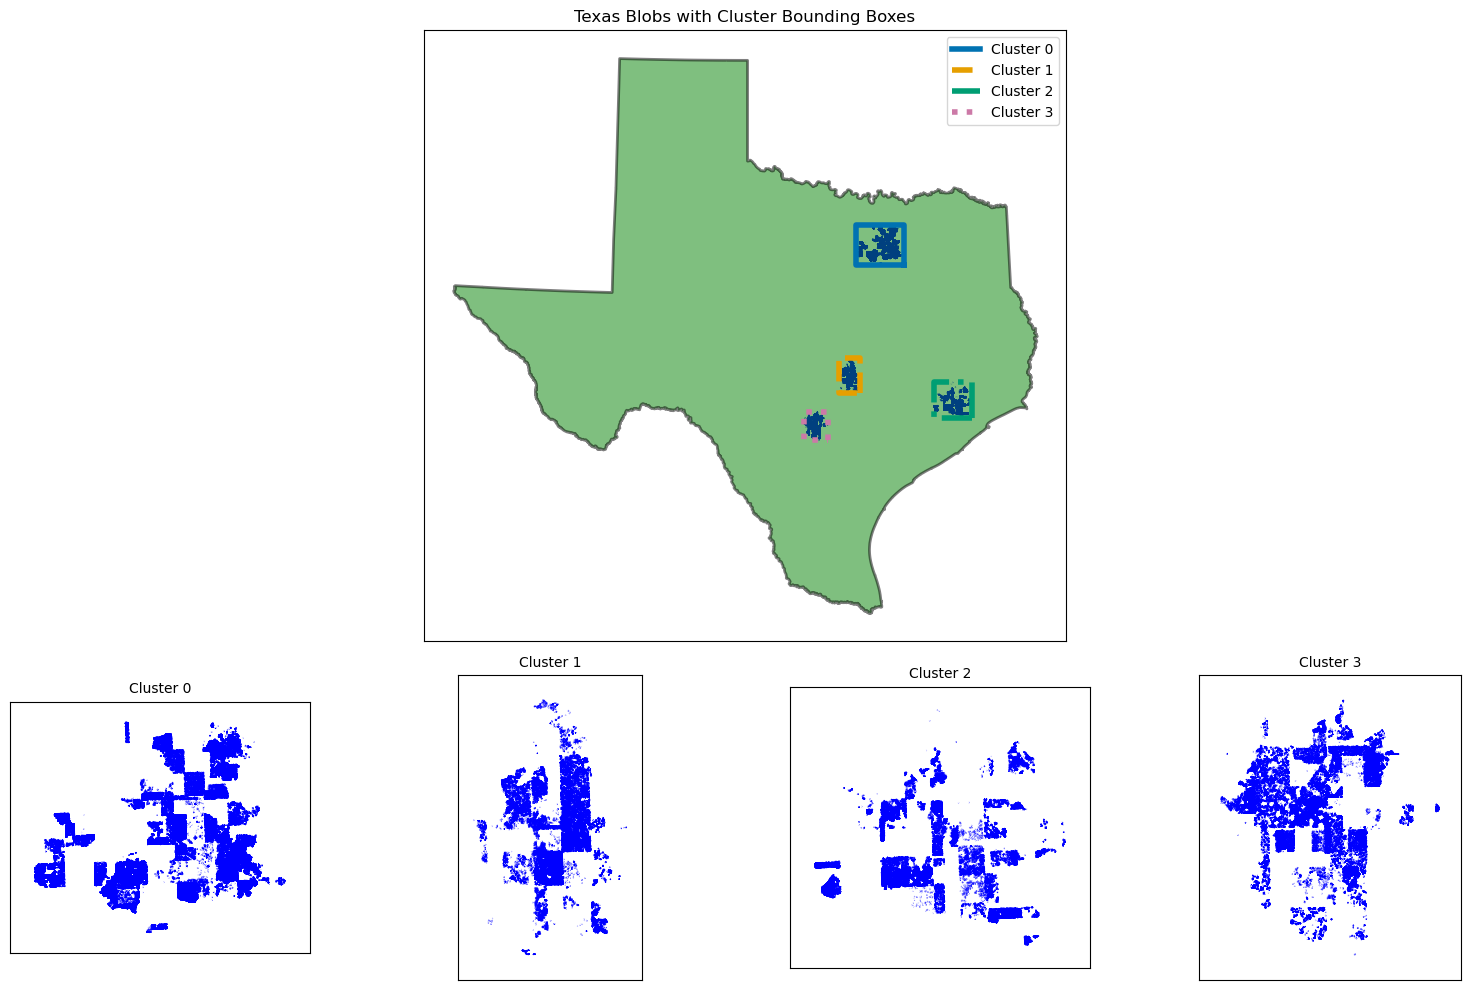

In [66]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans

# Assume gdf is your GeoDataFrame with the polygon data in Texas
# Compute centroids
# Reproject to a Texas-appropriate projected CRS (EPSG:3083)
gdf_projected = gdf.to_crs("EPSG:3083")
print("computing centroids after reprojection")
gdf_projected['centroid'] = gdf_projected.geometry.centroid
gdf_projected['centroid_x'] = gdf_projected.centroid.x
gdf_projected['centroid_y'] = gdf_projected.centroid.y

# Run k-means clustering (ensure coordinates are in a projected CRS if precision matters)
print('running kmeans')
X = gdf_projected[['centroid_x', 'centroid_y']].values
kmeans = KMeans(n_clusters=4, random_state=42)
gdf_projected['cluster'] = kmeans.fit_predict(X)

# Compute bounding boxes for each cluster
print('compute boxes')
clusters = {}
for cluster_label, group in gdf_projected.groupby('cluster'):
    minx, miny, maxx, maxy = group.total_bounds
    clusters[cluster_label] = box(minx, miny, maxx, maxy)

# Define a list of unique line styles
line_styles = ['-', '--', '-.', ':']
# line_styles = ['-', '-', '-', '-']
line_colors = ['#0072B2', '#E69F00', '#009E73', '#CC79A7']

# Plotting main Texas boundary, the polygons, and the bounding boxes
print('plotting main texas boundary')
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

# Main plot
print('main plot')
ax_main = fig.add_subplot(gs[0])
gdf_projected.plot(ax=ax_main, facecolor='none', edgecolor='blue', linewidth=1)

# plot the Texas boundary
texas_boundary = gpd.read_file('data/Texas_State_Boundary_1106215059088919288.geojson')
texas_boundary = texas_boundary.to_crs("EPSG:3083")
texas_boundary.plot(ax=ax_main, alpha=0.5, color='green', edgecolor='black', linewidth=2)

# Plot bounding boxes with unique line styles
for cluster_label, bbox in clusters.items():
    xs, ys = bbox.exterior.xy
    style = line_styles[cluster_label % len(line_styles)]  # use modulus to avoid index error
    color = line_colors[cluster_label % len(line_colors)]
    ax_main.plot(xs, ys, color=color, linestyle=style, linewidth=4, label=f'Cluster {cluster_label}')

ax_main.set_title('Texas Blobs with Cluster Bounding Boxes')
ax_main.legend()
ax_main.set_xticks([])
ax_main.set_yticks([])

# Create subplots for each cluster
print('create subplots for each cluster')
gs_sub = gridspec.GridSpecFromSubplotSpec(
    nrows=1, 
    ncols=4, 
    subplot_spec=gs[1],
    wspace=0.3)

for cluster_label, group in gdf_projected.groupby('cluster'):
    ax = fig.add_subplot(gs_sub[cluster_label])
    group.plot(ax=ax, facecolor='none', edgecolor='blue')
    # Adjust view to the cluster bounding box with a little buffer
    minx, miny, maxx, maxy = group.total_bounds
    x_buffer = (maxx - minx) * 0.1
    y_buffer = (maxy - miny) * 0.1
    ax.set_xlim(minx - x_buffer, maxx + x_buffer)
    ax.set_ylim(miny - y_buffer, maxy + y_buffer)
    ax.set_title(f'Cluster {cluster_label}', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

plt.savefig('figs/blob_map_with_clusters.png', bbox_inches='tight')

plt.show()

## 1. Non-optimized process

### 1.1. Data encoding, storage, and fetching

We will use PostgreSQL and string storage for geographic information.

#### Make copy of polygon layer and convert to non-geospatial-native string datatype (WKT)

In [63]:
gdf_wkt = gdf.copy()

In [64]:
# convert WKT versions to strings
gdf_wkt = h.convert_col_to_string(gdf)

# check result
gdf_wkt.head(3)

/Users/sra/files/projects/matching_optimization/helpers.py:226: UserWarning: Geometry column does not contain geometry.
  df[col] = df[col].apply(lambda geom: to_wkt(geom) if isinstance(geom, BaseGeometry) else str(geom))


Function `convert_col_to_string` executed in 12.0565 sec, CPU: 3.60%, Memory: 720.61MB


,BLOB_ID,FULL_IMG_ID,POINT,SIZE,POLYGON_BOUNDRY_BOX,BLOB_POLYGON,GEO_HASHES,CONSTRUCTION_STAGE,BUILDING_TYPE,CS_MODEL_ID,...,IS_OVERLAPPING_FOOTPRINT,IS_OVERLAPPING_ROAD,FOOTPRINT_ID,ROAD_DATA_ID,pgt_ctid,geometry,centroid,centroid_x,centroid_y,cluster
0,BID_4b0de362-432b-4169-880b-2502fe191e45,FIID_eeca1e04-8ba1-43cb-931c-81c560491477_2024...,POINT (-96.57220292317847 32.777977159601775),519,POLYGON ((-96.57224768518518 32.77805324074072...,POLYGON ((-96.57224768518518 32.77797916666665...,9vg66rn,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,FP_ID_36b25e18-56d6-482d-8f54-dac7c70c6687,None,"(1000,6)","POLYGON ((-96.572248 32.777979, -96.572243 32....",POINT (-96.57220 32.77798),-96.572203,32.777977,0
1,BID_8ae754b5-026d-4aac-9b9c-7b473bcf1f79,FIID_46cf3f0f-2345-41e0-8e50-fcf561da16c4_2024...,POINT (-95.33409120370364 29.674920974576246),1180,POLYGON ((-95.33415972222215 29.67505787037034...,POLYGON ((-95.33415972222215 29.67503935185182...,9vk0yd5,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,FP_ID_c7fa7535-5ebb-4132-9814-e695c737a316,None,"(1000000,6)","POLYGON ((-95.33416 29.675039, -95.334155 29.6...",POINT (-95.33409 29.67492),-95.334091,29.674920,2
2,BID_ea519744-3092-4bb3-a340-19afe400056f,FIID_f7968076-35bc-42c8-b417-f88e8fafd619_2024...,POINT (-96.74267940156228 33.196998841454544),1017,POLYGON ((-96.74277546296292 33.19707175925927...,POLYGON ((-96.74277546296292 33.19699305555556...,9vghye6,ROOF,RESIDENTAL SF DETACHED,MID_6bf26a1d-f36e-4364-bc9d-d759d5c75d74,...,True,False,FP_ID_6f9bcbaf-4075-4ceb-aab1-ccdc562744e7,None,"(10000001,2)","POLYGON ((-96.742775 33.196993, -96.742766 33....",POINT (-96.74268 33.19700),-96.742679,33.196999,0


#### Save in PostgreSQL database

This is a demonstration version of what a "non-geospatial-native" data pipeline may look like, with the primary example being that the polygons are stored as strings, not in a spatial-friendly datatype, and the data is stored in a PostgreSQL database.

In [65]:
# convert to tuples for postgres
gdf_wkt = h.df_itertuple(gdf_wkt)

Function `df_itertuple` executed in 3.6175 sec, CPU: 2.70%, Memory: 96.81MB


In [12]:
# Convert to tuples
prev_month_blobs_wkt = h.df_itertuple(prev_month_blobs_wkt)
curr_month_blobs_wkt = h.df_itertuple(curr_month_blobs_wkt)

Function `df_itertuple` executed in 0.0020 sec, CPU: 0.00%, Memory: 0.00MB
Function `df_itertuple` executed in 0.0018 sec, CPU: 0.00%, Memory: 0.00MB


Create PostgreSQL database if it doesn't exist already. We will be using the default settings. If they need to be adjusted, refer to [`helpers.py`](helpers.py).

In [13]:
h.create_pg_db()

Database blob_matching already exists.
Function `create_pg_db` executed in 0.0220 sec, CPU: 0.00%, Memory: 0.00MB


Create and insert into tables:

In [14]:
prev_month_blobs.head(1)

,geometry,id,geohash
0,"POLYGON ((-81.17040 26.94651, -81.08065 26.946...",e22ae998-6873-4924-93fb-d2618235dda8,dhy33u


In [15]:
prev_month_blobs_wkt[0]

('POLYGON ((-81.170395 26.946513, -81.080646 26.946513, -81.080646 26.975474, -81.170395 26.975474, -81.170395 26.946513))',
 'e22ae998-6873-4924-93fb-d2618235dda8',
 'dhy33u')

In [16]:
h.create_pg_table(table_name='prev_blobs_wkt', data=prev_month_blobs_wkt, truncate=True)
h.create_pg_table(table_name='curr_blobs_wkt', data=curr_month_blobs_wkt, truncate=True)

Table prev_blobs_wkt truncated.
Inserted 10000 records into prev_blobs_wkt.
Function `create_pg_table` executed in 0.4322 sec, CPU: 0.00%, Memory: 0.00MB
Table curr_blobs_wkt truncated.
Inserted 10000 records into curr_blobs_wkt.
Function `create_pg_table` executed in 0.3769 sec, CPU: 0.00%, Memory: 0.00MB


Retrieve data as GeoDataFrames to confirm that it worked:

In [17]:
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

Retrieved 10000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0460 sec, CPU: 7.40%, Memory: 12.42MB
Retrieved 10000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0440 sec, CPU: 20.60%, Memory: 5.23MB


Compare the tables before and after for a sanity check:

In [18]:
df_prev.head()

,geometry,id,geohash
0,"POLYGON ((-81.170395 26.946513, -81.080646 26....",e22ae998-6873-4924-93fb-d2618235dda8,dhy33u
1,"POLYGON ((-81.31626 27.176188, -81.30139 27.17...",dac8e2f3-e09b-49a0-b8e4-d7a65eb02d3c,dhy4tz
2,"POLYGON ((-81.45706 27.23212, -81.385653 27.23...",609e736e-86f3-4cf6-8431-f6c4e758e34c,dhy55j
3,"POLYGON ((-80.861484 27.337506, -80.777282 27....",060438ef-f5c2-4379-859d-9a2ee8086893,dhye8f
4,"POLYGON ((-81.188677 27.33882, -81.089889 27.3...",893f78cc-d272-4042-b7cd-f61afee7968a,dhy79e


In [19]:
prev_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.17040 26.94651, -81.08065 26.946...",e22ae998-6873-4924-93fb-d2618235dda8,dhy33u
1,"POLYGON ((-81.31626 27.17619, -81.30139 27.176...",dac8e2f3-e09b-49a0-b8e4-d7a65eb02d3c,dhy4tz
2,"POLYGON ((-81.45706 27.23212, -81.38565 27.232...",609e736e-86f3-4cf6-8431-f6c4e758e34c,dhy55j
3,"POLYGON ((-80.86148 27.33751, -80.77728 27.337...",060438ef-f5c2-4379-859d-9a2ee8086893,dhye8f
4,"POLYGON ((-81.18868 27.33882, -81.08989 27.338...",893f78cc-d272-4042-b7cd-f61afee7968a,dhy79e


Confirm that the original blob dfs and the retrieved dfs are the same length:

In [20]:
def round_geometry(geom, precision=6):
    """Round all coordinates of a geometry to a given precision."""
    return shapely.wkt.loads(shapely.wkt.dumps(geom, rounding_precision=precision))

# Convert both to sets of rounded WKT strings
set_prev_month_blobs = set(prev_month_blobs['geometry'].apply(lambda g: round_geometry(g, precision=6).wkt))
set_df_prev = set(df_prev['geometry'].apply(lambda g: round_geometry(g, precision=6).wkt))

# Find common, missing, and extra geometries
common_geometries = set_prev_month_blobs & set_df_prev
missing_from_retrieved = set_prev_month_blobs - set_df_prev
extra_in_retrieved = set_df_prev - set_prev_month_blobs

# Print summary
print(f"Number of matching geometries: {len(common_geometries)}")
print(f"Missing geometries in retrieved table: {len(missing_from_retrieved)}")
print(f"Extra geometries in retrieved table: {len(extra_in_retrieved)}")

# Show an example missing/extra geometry for debugging
if missing_from_retrieved:
    print("Example missing record:", next(iter(missing_from_retrieved)))

if extra_in_retrieved:
    print("Example extra record:", next(iter(extra_in_retrieved)))

Number of matching geometries: 10000
Missing geometries in retrieved table: 0
Extra geometries in retrieved table: 0


It worked! Now we can proceed to "matching" any "previous" polygons that overlap with the "current" polygons.

### 1.2. Searching for Overlaps

We will search for overlapping polygons using GeoPandas.

In [21]:
start = datetime.datetime.now()
print('Start time:', start)
postgresql_details = h.pg_details()
num_workers = 4
p.run_parallel_matching_with_grid(
    table_prev='prev_blobs_wkt', 
    table_curr='curr_blobs_wkt', 
    output_table='matched_results', 
    postgresql_details=postgresql_details, 
    db_name='blob_matching', 
    num_workers=num_workers,
    verbose=2
    )
end = datetime.datetime.now()
print('End time:', end)
print('Total time:', end - start)

Start time: 2025-03-06 17:46:15.641023
Table matched_results created successfully.
Total partitions to process: 4
Total matches found: 1559
Logging listener has shut down.
Function `run_parallel_matching_with_grid` executed in 2.3487 sec, CPU: 40.00%, Memory: 85.81MB
End time: 2025-03-06 17:46:17.990345
Total time: 0:00:02.349322


Confirm that the postgres matching table has the same number of matches:

In [22]:
count = h.retrieve_pg_table(table_name='matched_results', count=True)

Total matches in matched_results: 1559
Function `retrieve_pg_table` executed in 0.0056 sec, CPU: 6.70%, Memory: 0.00MB


In [23]:
# save log files as .parquet
h.convert_logs_to_parquet(csv_path=Path('logs/timing_results.csv'),
                          log_path=Path('logs/timing.log'))

Converted logs/timing_results.csv to logs/timing_results.parquet
Converted logs/timing.log to logs/timing_log.parquet


View the overall polygon layers and then some subplots with locations of the matched polygons:

Retrieved 10000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0549 sec, CPU: 12.70%, Memory: 51.36MB
Retrieved 10000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0548 sec, CPU: 45.20%, Memory: 0.25MB
Retrieved 1559 records from matched_results.


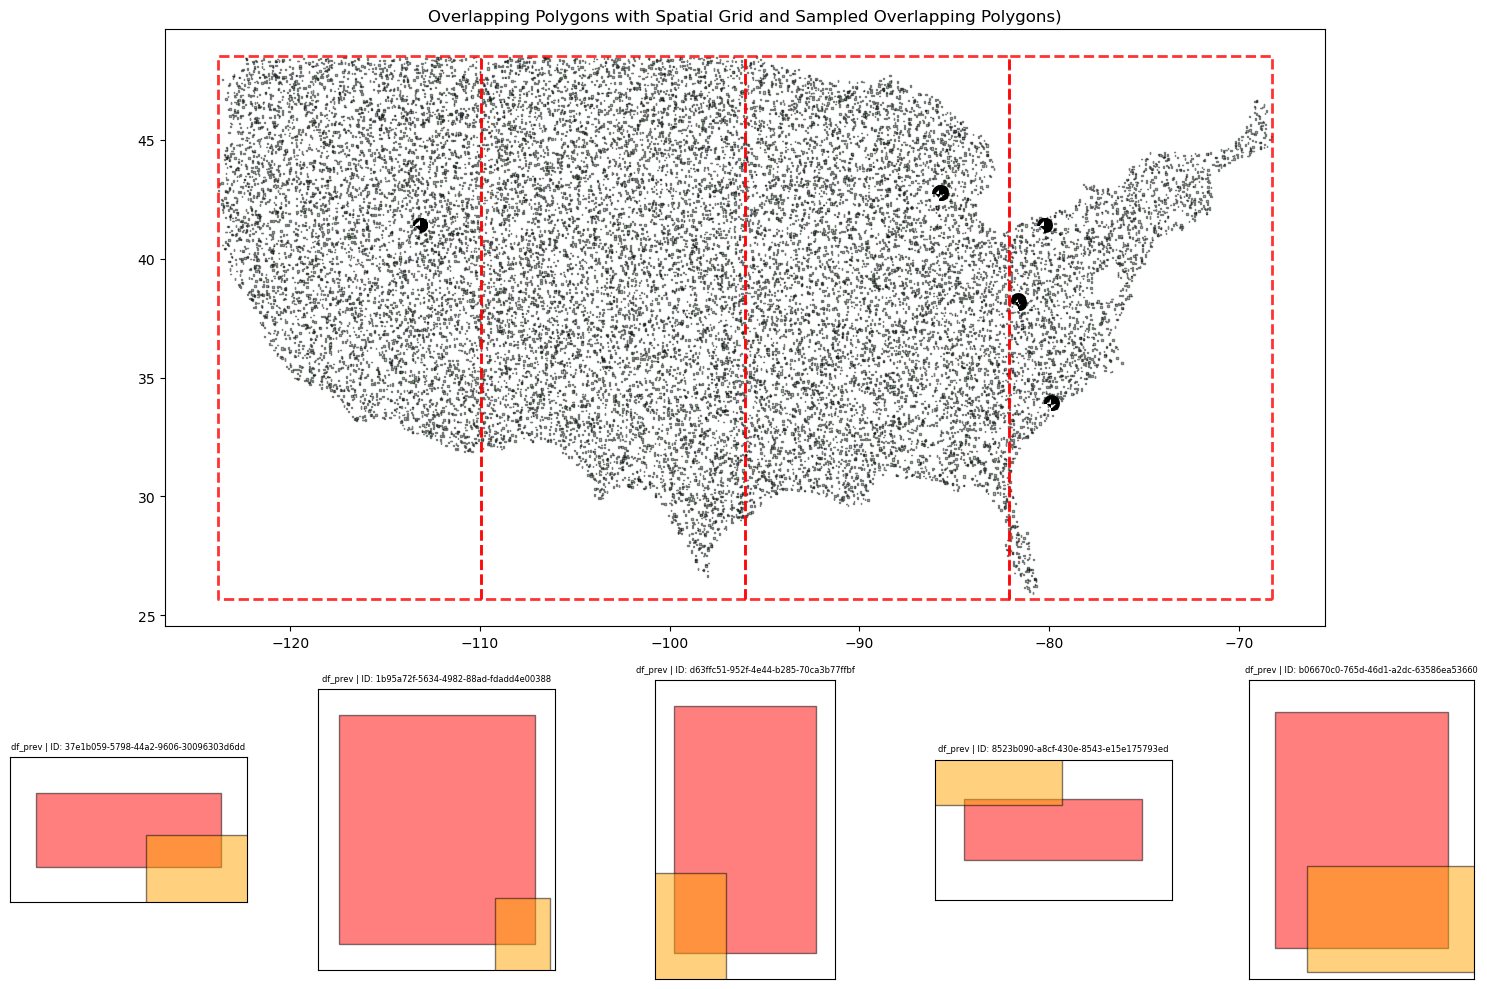

In [24]:
# --- Retrieve Data from PostgreSQL ---
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

# Ensure they are GeoDataFrames
df_prev = gpd.GeoDataFrame(df_prev, geometry='geometry', crs="EPSG:4326")
df_curr = gpd.GeoDataFrame(df_curr, geometry='geometry', crs="EPSG:4326")

# Retrieve matches table
table_name = 'matched_results'
postgresql_details['dbname'] = 'blob_matching'
conn = psycopg2.connect(**postgresql_details)
cur = conn.cursor()
cur.execute(f"SELECT prev_id, curr_id FROM {table_name};")
rows = cur.fetchall()
cur.close()
conn.close()

# Convert matches to DataFrame
matches = pd.DataFrame(rows, columns=["prev_id", "curr_id"])
print(f"Retrieved {len(matches)} records from {table_name}.")

# Find matching polygons
overlapping_a = df_prev[df_prev['id'].isin(matches['prev_id'])]
overlapping_b = df_curr[df_curr['id'].isin(matches['curr_id'])]

# --- Sample Overlapping Polygons ---
# Merge to ensure exact pairs before sampling
merged = matches.merge(overlapping_a, left_on="prev_id", right_on="id").merge(
    overlapping_b, left_on="curr_id", right_on="id", suffixes=("_prev", "_curr")
)

# Sample up to 5 matched pairs
sampled = merged.sample(n=min(5, len(merged)), random_state=42)

# debug
# print("Sampled columns:", sampled.columns)
# print("Overlapping_a columns:", overlapping_a.columns)
# print("Overlapping_b columns:", overlapping_b.columns)

# Extract individual DataFrames
sample_a = sampled[[col + "_prev" for col in overlapping_a.columns]]
sample_b = sampled[[col + "_curr" for col in overlapping_b.columns]]

# debug
# print("sample_a columns:", sample_a.columns)
# print("sample_b columns:", sample_b.columns)

# --- Define Figure Layout ---
fig = plt.figure(figsize=(15, 10))

# Main plot (2x height), subplots (1x height)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# --- Main Plot: Initial Polygons ---
ax_main = fig.add_subplot(gs[0])
df_prev.plot(ax=ax_main, color='lightblue', edgecolor='black', alpha=0.5, label="Previous", zorder=1)
df_curr.plot(ax=ax_main, color='lightgreen', edgecolor='black', alpha=0.5, label="Current", zorder=1)

# Highlight sampled polygons (plot the correct 'geometry' column directly)
sample_a.set_geometry('geometry_prev').plot(ax=ax_main, color='none', edgecolor='yellow', linewidth=0.01, linestyle='dashed', zorder=3)
sample_b.set_geometry('geometry_curr').plot(ax=ax_main, color='none', edgecolor='magenta', linewidth=0.01, linestyle='dashed', zorder=3)

# Emphasize selected polygons (plot the correct 'geometry' column directly)
sample_a.set_geometry('geometry_prev').plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)
sample_b.set_geometry('geometry_curr').plot(ax=ax_main, color='none', edgecolor='black', linewidth=10, linestyle='solid', zorder=4)

ax_main.set_title("Overlapping Polygons with Spatial Grid and Sampled Overlapping Polygons)")

# --- Add spatial grid from parallel_matching process
spatial_grid = p.create_spatial_grid(df_prev, num_workers)
spatial_grid.boundary.plot(ax=ax_main, color='red', linewidth=2, linestyle="--", alpha=0.8, label="Grid Partitions")

# --- Dynamic Subplots (Centered Below) ---
sample_size = 5
gs_subplots = gridspec.GridSpecFromSubplotSpec(1, sample_size, subplot_spec=gs[1], wspace=0.3)

for i, (idx, row) in enumerate(sample_a.iterrows()):
    ax = fig.add_subplot(gs_subplots[0, i])
    subset_a = sample_a.iloc[[i]]
    subset_b = sample_b.iloc[[i]]

    # Set geometry and plot explicitly by accessing the geometry
    subset_a = subset_a.set_geometry('geometry_prev')  # Ensure geometry is set
    subset_b = subset_b.set_geometry('geometry_curr')  # Ensure geometry is set

    # Plot the geometries explicitly
    subset_a.plot(ax=ax, color="red", edgecolor="black", alpha=0.5)
    subset_b.plot(ax=ax, color="orange", edgecolor="black", alpha=0.5)

    # Adjust zoom
    bounds = subset_a.geometry.bounds.values[0]  # Explicitly use .geometry for bounds
    buffer = 0.01
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

    # Titles & Aesthetics
    ax.set_title(f"df_prev | ID: {row['id_prev']}", fontsize=6)  # Use the appropriate ID column
    ax.set_xticks([])  
    ax.set_yticks([])

# Adjust layout and show
plt.tight_layout()

# plt.savefig('figs/overlapping_polygons_map_5k.pdf', bbox_inches='tight')
# plt.savefig('figs/overlapping_polygons_map_5k.png', bbox_inches='tight')

plt.savefig('figs/overlapping_polygons_map_10k.pdf', bbox_inches='tight')
plt.savefig('figs/overlapping_polygons_map_10k.png', bbox_inches='tight')

plt.show()

## 2. Optimized Approach

Having demonstrated a reasonable if not optimized way of matching polygons, we will now make use of geospatial-native tools to hopefully match polygons much more quickly.

My workflow centers around `DuckDB` and `H3` along with the `.parquet` format to efficiently store, retrieve, and process geospatial data. We will use `Apache Iceberg` as a layer over the parquet file as it allows for more robust table handling.

1. Prepare GeodataFrames with H3 Polyfill and parent hexagons at lower resolution.
   * Save as an Iceberg table.

2. Use DuckDB and the H3 extension to execute spatial SQL queries to find overlapping polygons with H3-based joins.

3. Save matching polygon IDs to a new Iceberg table.

4. Visualize the results.

### 2.1. Add H3 data to the blobs

H3 is a modern and efficient geospatial index paradigm that divides the world into nested hexagons.

In [25]:
prev_month_blobs.head()

,geometry,id,geohash
0,"POLYGON ((-81.17040 26.94651, -81.08065 26.946...",e22ae998-6873-4924-93fb-d2618235dda8,dhy33u
1,"POLYGON ((-81.31626 27.17619, -81.30139 27.176...",dac8e2f3-e09b-49a0-b8e4-d7a65eb02d3c,dhy4tz
2,"POLYGON ((-81.45706 27.23212, -81.38565 27.232...",609e736e-86f3-4cf6-8431-f6c4e758e34c,dhy55j
3,"POLYGON ((-80.86148 27.33751, -80.77728 27.337...",060438ef-f5c2-4379-859d-9a2ee8086893,dhye8f
4,"POLYGON ((-81.18868 27.33882, -81.08989 27.338...",893f78cc-d272-4042-b7cd-f61afee7968a,dhy79e


In [26]:
# import duckdb
# importlib.reload(h)

# df_prev, df_curr = h.create_h3_info_parallel(df_prev=df_prev, df_curr=df_curr)

# df_prev.head(3)

In [28]:
importlib.reload(h)

iceberg_dir = Path("iceberg")
iceberg_dir.mkdir(parents=True, exist_ok=True)
print(df_prev.columns)
print(df_curr.columns)

df_prev, df_curr = h.create_h3_info_parallel_new(df_prev=df_prev, 
                                                 df_curr=df_curr,
                                                 iceberg_path=iceberg_dir)

df_prev.head(3)

Index(['geometry', 'id', 'geohash', 'geometry_wkt'], dtype='object')
Index(['geometry', 'id', 'geohash', 'geometry_wkt'], dtype='object')


/Applications/Anaconda/anaconda3/envs/geo/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Function `process_h3_info_chunk` executed in 0.4542 sec, CPU: 9.20%, Memory: 7.22MB
Function `process_h3_info_chunk` executed in 0.4827 sec, CPU: 9.00%, Memory: 6.80MB
Function `process_h3_info_chunk` executed in 0.4822 sec, CPU: 9.50%, Memory: 7.53MB
Function `process_h3_info_chunk` executed in 0.5032 sec, CPU: 8.80%, Memory: 9.23MB
Function `process_h3_info_chunk` executed in 0.4801 sec, CPU: 57.10%, Memory: 0.00MB
Function `process_h3_info_chunk` executed in 0.4942 sec, CPU: 9.30%, Memory: 38.52MB
Function `process_h3_info_chunk` executed in 0.5219 sec, CPU: 39.40%, Memory: 25.70MB
Function `process_h3_info_chunk` executed in 0.5230 sec, CPU: 64.10%, Memory: 25.48MB


ConnectionError: HTTPConnectionPool(host='localhost', port=8181): Max retries exceeded with url: /v1/config (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x175f3b510>: Failed to establish a new connection: [Errno 61] Connection refused'))

# Notes on original process

geohash polygon into a larger region
match blobs using multiprocessing (mp.Process) and geopandas
find blobs from previous month that do not have a match

# 1 imports and setup

```python
import os, sys, traceback
import argparse
import cv2
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from skimage import io, color, measure
from tqdm import tqdm
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.validation import make_valid
import PIL
from PIL import Image, ImageDraw, ImageEnhance
import uuid
import multiprocessing as mp
from datetime import datetime
from sqlalchemy import or_
from sqlmodel import SQLModel, Session, create_engine, select
from pathlib import Path
```

## Key takeaways
- Uses Pandas and GeoPandas for data processing.
- Uses Shapely for geospatial geometry operations.
- Uses multiprocessing (mp) to parallelize the blob-matching process.
- Uses SQLAlchemy and SQLModel for database operations.

# 2 High-level script overview
The script is designed to match blobs (spatial objects) between two months and classify them into different business categories.

General Workflow
1. Fetch blobs from the previous and current months.
1. Convert the region of interest (state, city, county, or geohash) into a list of geohashes.
1. Parallelized Matching Process:
1. Process multiple geohashes at once using multiprocessing.
1. Find corresponding blobs from previous months for each geohash.
1. Classify blobs based on construction stage progression.
1. Identify blobs that are missing in the current month and "impute" them.
1. Save results into the database.

# 3 Blob classification logic

# 4 Blob matching

- Matches blobs between months using polygon intersections.
- Uses Shapely to validate geometries and check for overlaps.
- Returns matched blob IDs.

## Multiprocessing Optimization
The script parallelizes blob matching by:
- Uses multiprocessing (mp.Process) to divide the dataset into smaller batches.
- Each batch of blobs is processed in parallel.
- Reduces runtime compared to a single-threaded approach.

# 5 Handling unmatched blobs
- Finds blobs from the previous month that do not have a match in the current month.
- These blobs are "imputed", meaning they are carried over into the new month.

# 6 Main class to orchestrate process
- Loads previous and current month blobs.
- Converts input regions (state, city, county) into geohashes.

# Summary
- Parallel processing is used to match blobs.
- Blobs are classified based on construction stages.
- Unmatched blobs are imputed for continuity.
- The script writes results to a database.